# Funciones Auxiliares

In [1]:
library(MASS)
library(rpart)
library(readr)
library(class)
install.packages("randomForest")
library(randomForest)
install.packages("e1071")
library(e1071)
install.packages("xgboost")
library(xgboost)
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




In [2]:
load("TP4.Rdata")
load("lampone.Rdata")
ls()

[1] "diag_test"  "diag_train" "esp_test"   "esp_train"  "lampone"   
[6] "RRL"

In [3]:
get_kfolds <- function(dataX, dataY, k = 5) {
  # Número de observaciones
  n <- nrow(dataX)

  # Crear índices aleatorios para la división
  set.seed(123)  # Para reproducibilidad
  indices <- sample(1:n)

  # Dividir los índices en k subconjuntos
  folds <- cut(indices, breaks = k, labels = FALSE)

  # Lista para almacenar los conjuntos de entrenamiento y prueba
  kfolds <- list()

  # Para cada fold, crear los conjuntos de entrenamiento y prueba
  for (i in 1:k) {
    # Índices para el conjunto de prueba
    test_indices <- which(folds == i)

    # Índices para el conjunto de entrenamiento
    train_indices <- setdiff(1:n, test_indices)

    # Subconjuntos de entrenamiento y prueba
    X_train <- dataX[train_indices, ]
    Y_train <- dataY[train_indices]
    X_test <- dataX[test_indices, ]
    Y_test <- dataY[test_indices]

    # Almacenar los conjuntos de entrenamiento y prueba en la lista
    kfolds[[i]] <- list(
      xTrain = X_train,
      yTrain = Y_train,
      xTest = X_test,
      yTest = Y_test
    )
  }

  return(kfolds)
}

In [4]:
errorTestProf <- function(train, test, arboles, eta, maxProfundidad) {
  xTrain <- as.matrix(train[,1:2])
  yTrain<- train[,3]

  xTest <- as.matrix(test[,1:2])
  yTest <- test[,3]

  erroresTrain <- list()
  erroresTest <- list()

  for(i in 1:maxProfundidad){
    xgb <- xgboost(data=xTrain, label=as.integer(yTrain)-1, objective="binary:hinge", nrounds=arboles,
    early_stopping_rounds=1000, eta=eta, max.depth=i, colsample_bytree=1, verbose=0,
    subsample=1)

    predicciones <- predict(xgb, xTest)
    predicciones <- ifelse(predicciones > 0.5, 1, 0)

    error <- mean(predicciones != (as.integer(yTest) - 1))

    erroresTest[[i]] <- error

    predicciones <- predict(xgb, xTrain)
    predicciones <- ifelse(predicciones > 0.5, 1, 0)

    error <- mean(predicciones != (as.integer(yTrain) - 1))

    erroresTrain[[i]] <- error
  }

  return(list(erroresTrain = erroresTrain, erroresTest = erroresTest))
}

# Ejercicio 1

In [ ]:
XGB.nrounds <- 200 #total de arboles/ciclos
XGB.eta <- 0.1 #learning rate, similar a redes
XGB.max.depth <-20

## Espirales con ruido

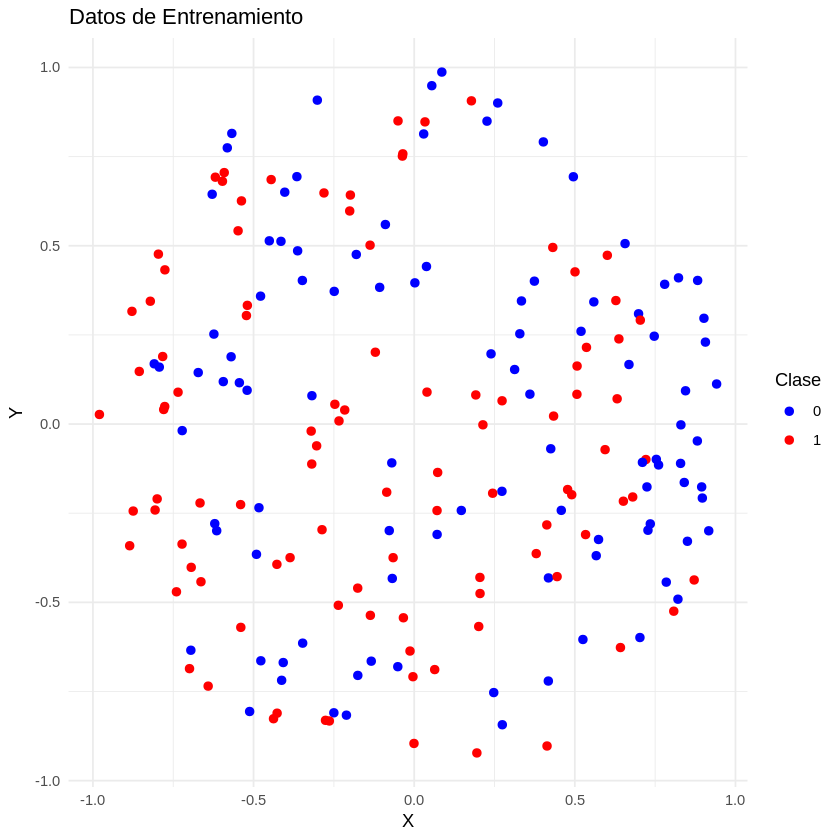

In [ ]:
train_df <- data.frame(
  X1 = esp_train[, 1], # Primera característica
  X2 = esp_train[, 2], # Segunda característica
  Clase = as.factor(esp_train[, 3]) # Clase (convertida a factor para colores)
)

# Graficar con ggplot2
ggplot(train_df, aes(x = X1, y = X2, color = Clase)) +
  geom_point(size = 2) + # Puntos con tamaño 2
  labs(title = "Datos de Entrenamiento",
       x = "X", y = "Y") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "red")) # Ajusta los colores si tienes solo 2 clases

In [ ]:
resultados <- errorTestProf(esp_train, esp_test, XGB.nrounds, XGB.eta, XGB.max.depth)

erroresTrain <- resultados$erroresTrain
erroresTest <- resultados$erroresTest

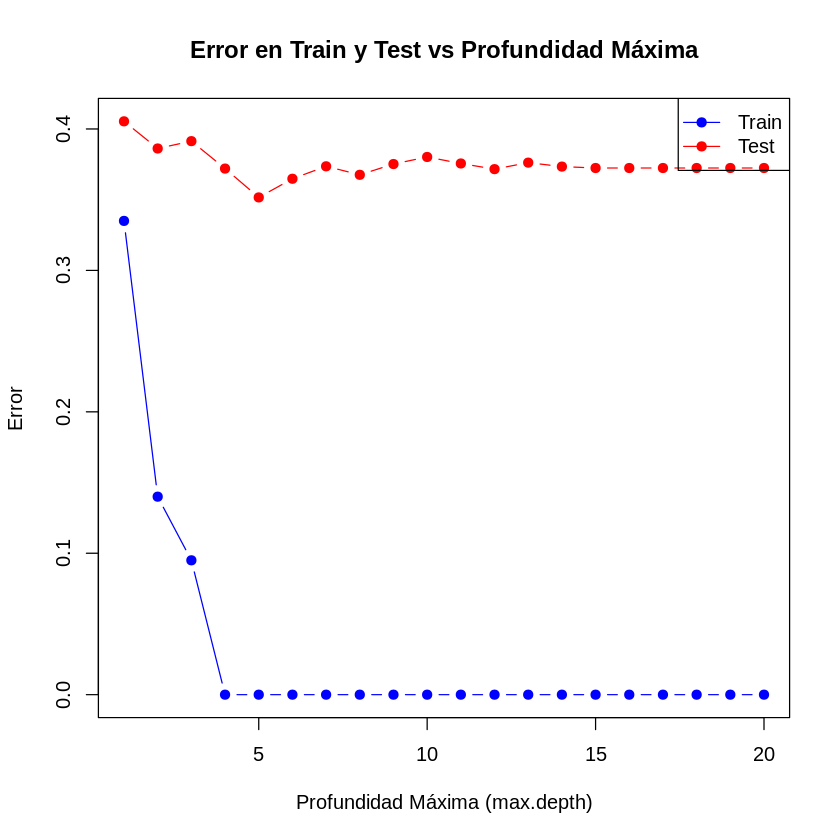

In [ ]:
plot(
  1:XGB.max.depth,
  erroresTrain,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad Máxima (max.depth)",
  ylab = "Error",
  main = "Error en Train y Test vs Profundidad Máxima",
  ylim = range(c(erroresTrain, erroresTest))
)

lines(
  1:XGB.max.depth,
  erroresTest,
  type = "b",
  col = "red",
  pch = 19
)

legend(
  "topright",
  legend = c("Train", "Test"),
  col = c("blue", "red"),
  pch = 19,
  lty = 1
)

### Comentarios

Comencé imprimiendo un gráfico de los datos de entrenamiento para observar cuánto se solapaban debido al ruido y con cuántos datos contábamos. Esto me permitió evaluar, a simple vista, si sería posible hacer una "predicción" razonable de nuevos datos.

Personalmente, me pareció casi incomprensible el gráfico, y dudé seriamente de que fuera posible realizar una buena predicción sobre los puntos de prueba.

Uno podría pensar que un error del 35% es elevado, pero al considerar el gráfico anterior, personalmente me sorprendió obtener un resultado significativamente mejor que el 50% esperado por azar.

Más allá de eso, el menor error encontrado fue del 35%, como ya se mencionó, y se alcanzó utilizando árboles de decisión con una profundidad de 5. Parece que tanto árboles más complejos (de mayor profundidad) como menos complejos (de menor profundidad) empeoraban el error.

## Diagonales

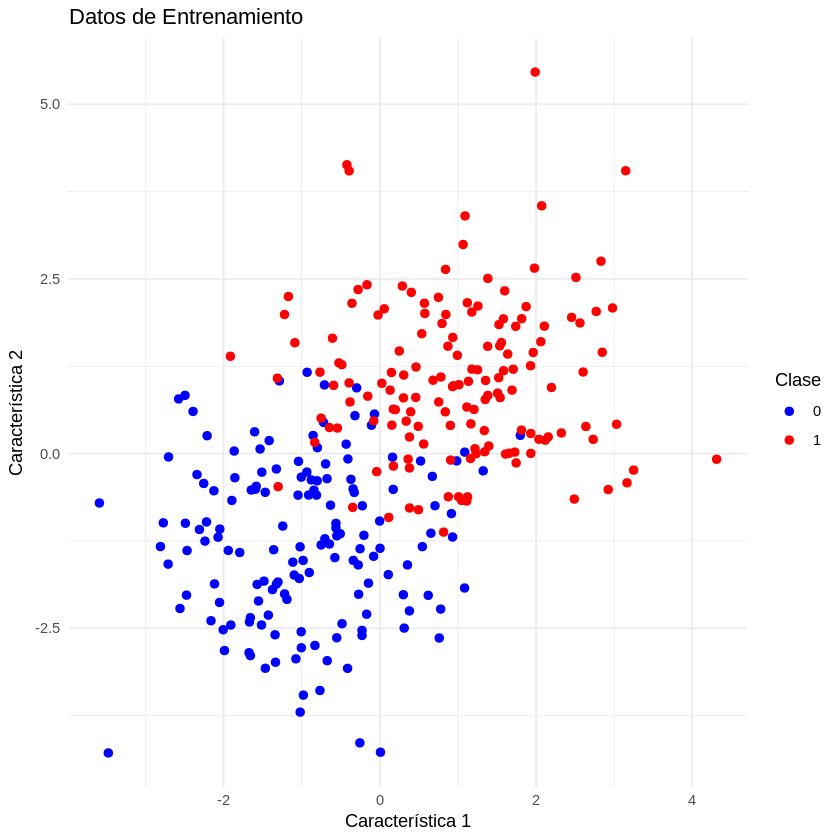

In [ ]:
train_df <- data.frame(
  X1 = diag_train[, 1], # Primera característica
  X2 = diag_train[, 2], # Segunda característica
  Clase = as.factor(diag_train[, 3]) # Clase (convertida a factor para colores)
)

# Graficar con ggplot2
ggplot(train_df, aes(x = X1, y = X2, color = Clase)) +
  geom_point(size = 2) + # Puntos con tamaño 2
  labs(title = "Datos de Entrenamiento",
       x = "Característica 1", y = "Característica 2") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "red")) # Ajusta los colores si tienes solo 2 clases

In [ ]:
resultados <- errorTestProf(diag_train, diag_test, XGB.nrounds, XGB.eta, XGB.max.depth)

erroresTrain <- resultados$erroresTrain
erroresTest <- resultados$erroresTest

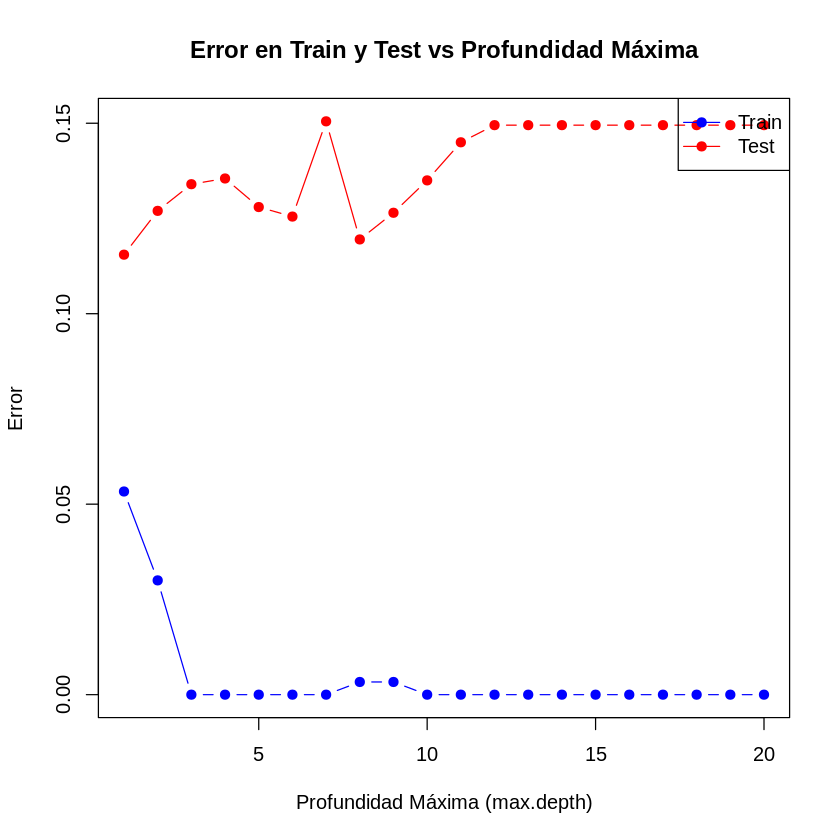

In [ ]:
plot(
  1:XGB.max.depth,
  erroresTrain,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad Máxima (max.depth)",
  ylab = "Error",
  main = "Error en Train y Test vs Profundidad Máxima",
  ylim = range(c(erroresTrain, erroresTest))
)

lines(
  1:XGB.max.depth,
  erroresTest,
  type = "b",
  col = "red",
  pch = 19
)

legend(
  "topright",
  legend = c("Train", "Test"),
  col = c("blue", "red"),
  pch = 19,
  lty = 1
)

### Comentarios

Aunque el problema de diagonales ya era conocido, no me pareció innecesario graficarlo nuevamente para tener una idea más clara de con qué estábamos trabajando.

El menor error se logró utilizando árboles de decisión de profundidad 1 (es decir, con un solo corte). Esto tiene sentido, ya que, como sabemos, los árboles de decisión intentan aproximar una recta diagonal (en este caso, y=−x) mediante divisiones sucesivas que maximicen la separación entre las clases. Estas divisiones se realizan de forma progresiva, ajustando los cortes sobre los puntos a lo largo de dicha recta.

# Ejercicio 2

In [ ]:
xTrain <- as.matrix(subset(RRL, select = -Tipo))
yTrain <- RRL[, "Tipo"]

mtrys <- c(69, 34, 17, 8, 4, 2, 1)
arboles <- 1000
tries <- 5

In [ ]:
erroresRRL <- numeric(length(mtrys))

for (i in 1:length(mtrys)) {

  mtry <- mtrys[i]  # Obtener el valor de mtry
  error <- 0

  for (j in 1:tries) {
    rf_model <- randomForest(x = xTrain, y = as.factor(yTrain),
                             ntree = arboles,
                             mtry = mtry,
                             importance = FALSE)

    error <- error + tail(rf_model$err.rate[, "OOB"], 1)
  }

  erroresRRL[i] <- error / tries  # Promedio de los errores OOB
}

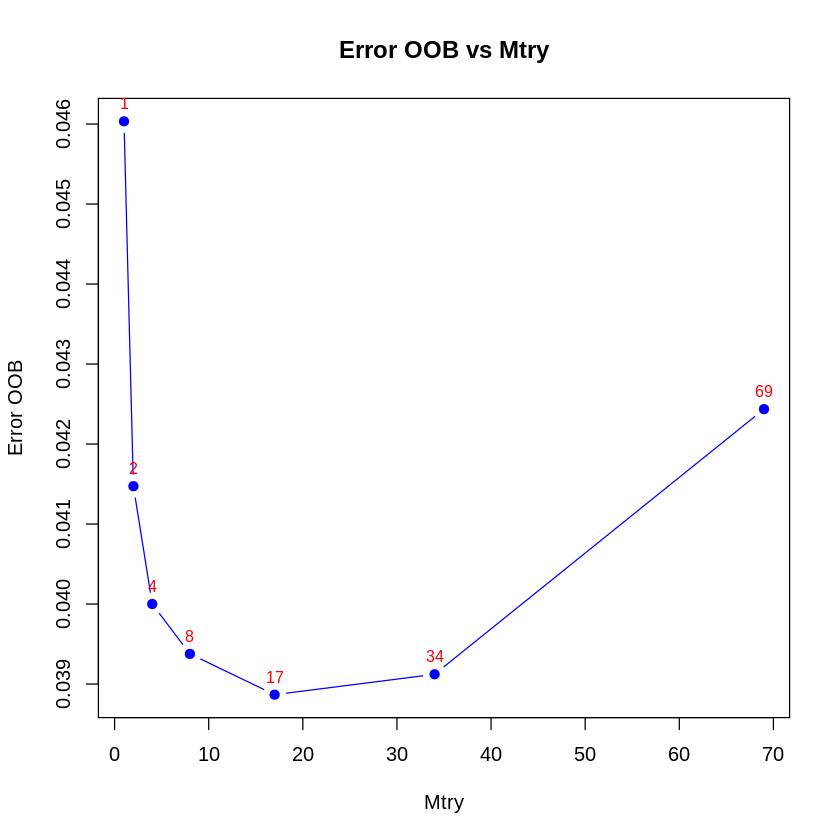

In [ ]:
plot(
  mtrys,
  erroresRRL,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Mtry",
  ylab = "Error OOB",
  main = "Error OOB vs Mtry",
  ylim = range(erroresRRL)
)

# Añadir los valores de mtrys como etiquetas a cada punto
text(mtrys, erroresRRL, labels = mtrys, pos = 3, cex = 0.8, col = "red")

## Comentarios

Según los resultados, el mejor valor para el parámetro Mtry (número de variables seleccionadas en cada iteración) fue 17.

Conectándolo con la teoría, este caso corresponde a un equilibrio en el que se seleccionaron suficientes variables como para introducir aleatoriedad entre las distintas iteraciones. Esto permitió que los árboles aprendieran aspectos diferentes del dataset. Al mismo tiempo, no se seleccionaron demasiadas variables, lo que garantizó que los árboles pudieran seguir especializándose adecuadamente en los distintos sectores del dataset.

Sin embargo, aunque el valor 17 para el parámetro Mtry resultó ser el óptimo, la diferencia de error con respecto al peor valor no superó el 1%. Por lo tanto, aunque la elección adecuada de este parámetro mejora la capacidad predictiva del modelo, su impacto en el error final no fue muy significativo en este caso.

# Ejercicio 3

In [5]:
dataX <- lampone[, -c(1, 143, ncol(lampone))]

dataY <- lampone[, 143]

## Seleccion Parametros

### Funciones

In [6]:
getDatasets <- function () {
  train_ratio <- 0.8

  n <- nrow(lampone)

  # Seleccionar índices aleatorios para entrenamiento
  train_indices <- sample(1:n, size = floor(train_ratio * n))

  # Crear los conjuntos de entrenamiento y prueba
  xBigTrain <- dataX[train_indices, ]
  yBigTrain <- dataY[train_indices]

  xBigTest <- dataX[-train_indices, ]
  yBigTest <- dataY[-train_indices]

  return(list(
    xBigTrain = xBigTrain,
    yBigTrain = yBigTrain,
    xBigTest = xBigTest,
    yBigTest = yBigTest
  ))
}

#### RF

In [7]:
lamponeRF <- function(x, y) {
  mtrys <- c(141, 70, 35, 17, 8, 4, 2, 1)
  arboles <- 1000
  tries <- 5

  erroresRF <- numeric(length(mtrys))

  for (i in 1:length(mtrys)) {

    mtry <- mtrys[i]
    error <- 0

    for (j in 1:tries) {
      rf_model <- randomForest(x = x, y = as.factor(y),
                              ntree = arboles,
                              mtry = mtry,
                              importance = FALSE)

      error <- error + tail(rf_model$err.rate[, "OOB"], 1)
    }

    erroresRF[i] <- error / tries
  }

  return (erroresRF)
}

#### XGB

In [8]:
lamponeXGB <- function(folds) {
  XGB.nrounds <- 200
  etas <- c(0.5, 0.3, 0.1, 0.05, 0.01)
  XGB.max.depth <- 20

  erroresXGBTrain <- vector("list", length(etas))
  erroresXGBTest <- vector("list", length(etas))

  for (i in 1:length(etas)) {
    eta <- etas[i]

    errorDepthTrain <- numeric(XGB.max.depth)
    errorDepthTest <- numeric(XGB.max.depth)

    for (j in 1:XGB.max.depth) {
      errorTrain <- 0
      errorTest <- 0

      for (fold in folds) {
        xTrain <- as.matrix(fold$xTrain)  # Convertir a matriz
        yTrain <- fold$yTrain
        xTest <- as.matrix(fold$xTest)  # Convertir a matriz
        yTest <- fold$yTest

        xgb <- xgboost(data = xTrain, label = as.integer(yTrain) - 1,
                      objective = "binary:hinge", nrounds = XGB.nrounds,
                      early_stopping_rounds = 1000, eta = eta, max.depth = j,
                      colsample_bytree = 1, verbose = 0, subsample = 1)

        # Error en train
        predicciones <- predict(xgb, xTrain)
        fold_error <- mean((predicciones > 0.5) != as.integer(yTrain) - 1)
        errorTrain <- errorTrain + fold_error

        # Error en test
        predicciones <- predict(xgb, xTest)
        fold_error <- mean((predicciones > 0.5) != as.integer(yTest) - 1)
        errorTest <- errorTest + fold_error
      }

      errorDepthTrain[j] <- errorTrain / k
      errorDepthTest[j] <- errorTest / k
    }

    # Guardar errores por eta
    erroresXGBTrain[[i]] <- errorDepthTrain
    erroresXGBTest[[i]] <- errorDepthTest
  }

  return(list(erroresXGBTrain = erroresXGBTrain, erroresXGBTest = erroresXGBTest))
}

#### SVM RBF (Radial Basis Function)


In [9]:
lamponeRBF <- function(folds) {
  costs <- c(1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000)

  gammas <- c(0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001)

  erroresRBFTrain <- vector("list", length(costs))
  erroresRBFTest <- vector("list", length(costs))

  for (i in 1:length(costs)) {
    cost <- costs[i]

    errorGammaTrain <- numeric(length(gammas))
    errorGammaTest <- numeric(length(gammas))

    for (j in 1:length(gammas)) {
      gamma <- gammas[j]

      errorTrain <- 0
      errorTest <- 0
      for (fold in folds) {
        xTrain <- fold$xTrain
        yTrain <- fold$yTrain
        xTest <- fold$xTest
        yTest <- fold$yTest

        svm_rbf <- suppressWarnings(
          svm(x = xTrain, y = as.factor(yTrain), kernel = "radial", cost = cost, gamma = gamma)
        )

        predTrain <- predict(svm_rbf, xTrain)
        errorTrain <- errorTrain + mean(predTrain != yTrain)

        predTest <- predict(svm_rbf, xTest)
        errorTest <- errorTest + mean(predTest != yTest)
      }

      errorGammaTrain[j] <- errorTrain / k
      errorGammaTest[j] <- errorTest / k
    }

    erroresRBFTrain[[i]] <- errorGammaTrain
    erroresRBFTest[[i]] <- errorGammaTest
  }

  return(list(erroresRBFTrain = erroresRBFTrain, erroresRBFTest = erroresRBFTest))
}

#### SVM Polinomial

In [10]:
lamponePol <- function(folds) {
  costs <- c(0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000)

  gammas <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)

  degrees <- c(1, 2, 3, 4, 5)

  erroresPolTrain <- vector("list", length(costs))
  erroresPolTest <- vector("list", length(costs))

  for (i in 1:length(costs)) {
    cost <- costs[i]

    errorGammaTrain <- vector("list", length(gammas))
    errorGammaTest <- vector("list", length(gammas))

    for (j in 1:length(gammas)) {
      gamma <- gammas[j]

      errorDegreeTrain <- numeric(length(degrees))
      errorDegreeTest <- numeric(length(degrees))

      for (l in 1:length(degrees)) {
        degree <- degrees[l]

        errorTrain <- 0
        errorTest <- 0

        for (fold in folds) {
          xTrain <- fold$xTrain
          yTrain <- fold$yTrain
          xTest <- fold$xTest
          yTest <- fold$yTest

          svm_pol <- suppressWarnings(
            svm(x = xTrain, y = as.factor(yTrain), kernel = "polynomial",
                cost = cost, degree = degree, gamma = gamma)
          )

          predTrain <- predict(svm_pol, xTrain)
          errorTrain <- errorTrain + mean(predTrain != yTrain)

          predTest <- predict(svm_pol, xTest)
          errorTest <- errorTest + mean(predTest != yTest)
        }

        errorDegreeTrain[l] <- errorTrain / k
        errorDegreeTest[l] <- errorTest / k
      }

      errorGammaTrain[[j]] <- errorDegreeTrain
      errorGammaTest[[j]] <- errorDegreeTest
    }

    erroresPolTrain[[i]] <- errorGammaTrain
    erroresPolTest[[i]] <- errorGammaTest
  }

  return(list(erroresPolTrain = erroresPolTrain, erroresPolTest = erroresPolTest))
}

### Calculos

In [ ]:
iterations <- 20
k <- 5

mtrys <- c(141, 70, 35, 17, 8, 4, 2, 1)
best_rf_count <- numeric(length(mtrys))

etas <- c(0.5, 0.3, 0.1, 0.05, 0.01)
max_depth <- 1:20
best_xgb_count <- matrix(0, nrow = length(etas), ncol = length(max_depth),
                            dimnames = list(etas, max_depth))

costsRBF <- c(1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000)
gammasRBF <- c(0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001)
best_rbf_count <- matrix(0, nrow = length(costsRBF), ncol = length(gammasRBF),
                            dimnames = list(costsRBF, gammasRBF))

costsPol <- c(0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000)
gammasPol <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
degreesPol <- c(1, 2, 3, 4, 5)
best_pol_count <- array(0, dim = c(length(costsPol), length(gammasPol), length(degreesPol)),
                           dimnames = list(costsPol, gammasPol, degreesPol))

for (iter in 1:iterations) {
  resultados <- getDatasets()
  x <- resultados$xBigTrain
  y <- resultados$yBigTrain

  folds <- get_kfolds(x, y, k)

  # RF
  erroresRF <- lamponeRF(x, y)

  min_error <- min(erroresRF)
  best_rf_count[erroresRF == min_error] <- best_rf_count[erroresRF == min_error] + 1

  # XGB
  resultadosXGB <- lamponeXGB(folds)
  erroresXGBTest <- resultadosXGB$erroresXGBTest

  min_error <- Inf
  best_eta_index <- NA
  best_depth_index <- NA
  for (eta_idx in seq_along(etas)) {
    for (depth_idx in seq_along(max_depth)) {
      error_promedio <- erroresXGBTest[[eta_idx]][depth_idx]
      if (error_promedio < min_error) {
        min_error <- error_promedio
      }
    }
  }

  for (eta_idx in seq_along(etas)) {
    for (depth_idx in seq_along(max_depth)) {
      error_promedio <- erroresXGBTest[[eta_idx]][depth_idx]
      if (error_promedio == min_error) {
        best_xgb_count[eta_idx, depth_idx] <- best_xgb_count[eta_idx, depth_idx] + 1
      }
    }
  }

  # SVM RBF
  resultadosRBF <- lamponeRBF(folds)
  erroresRBFTest <- resultadosRBF$erroresRBFTest

  min_error <- Inf
  best_cost_index <- NA
  best_gamma_index <- NA
  for (cost_idx in seq_along(costsRBF)) {
    for (gamma_idx in seq_along(gammasRBF)) {
      error_promedio <- erroresRBFTest[[cost_idx]][gamma_idx]
      if (error_promedio < min_error) {
        min_error <- error_promedio
      }
    }
  }

  for (cost_idx in seq_along(costsRBF)) {
    for (gamma_idx in seq_along(gammasRBF)) {
      error_promedio <- erroresRBFTest[[cost_idx]][gamma_idx]
      if (error_promedio == min_error) {
        best_rbf_count[cost_idx, gamma_idx] <- best_rbf_count[cost_idx, gamma_idx] + 1
      }
    }
  }

  # SVM Polinomial
  resultadosPol <- lamponePol(folds)
  erroresPolTest <- resultadosPol$erroresPolTest

  min_error <- Inf
  for (cost_idx in seq_along(costsPol)) {
    for (gamma_idx in seq_along(gammasPol)) {
      for (degree_idx in seq_along(degreesPol)) {
        error_promedio <- erroresPolTest[[cost_idx]][[gamma_idx]][degree_idx]
        if (error_promedio < min_error) {
          min_error <- error_promedio
        }
      }
    }
  }

  for (cost_idx in seq_along(costsPol)) {
    for (gamma_idx in seq_along(gammasPol)) {
      for (degree_idx in seq_along(degreesPol)) {
        error_promedio <- erroresPolTest[[cost_idx]][[gamma_idx]][degree_idx]
        if (error_promedio == min_error) {
          best_pol_count[cost_idx, gamma_idx, degree_idx] <- best_pol_count[cost_idx, gamma_idx, degree_idx] + 1
        }
      }
    }
  }
}

cat("----- RF -----\n")
print(setNames(best_rf_count, mtrys))

cat("----- XGB -----\n")
print(best_xgb_count)

cat("----- SVM RBF -----\n")
print(best_rbf_count)

cat("----- SVM Polinomial -----\n")
print(best_pol_count)

----- RF -----
141  70  35  17   8   4   2   1 
  0   2   4  10   6   5   2   0 
----- XGB -----
     1 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
0.5  9 9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
0.3  4 9 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
0.1  5 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
0.05 4 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
0.01 3 8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
----- SVM RBF -----
      1e-09 1e-08 1e-07 1e-06 1e-05
1000      0     0     2     1     1
10000     0     2     2     1     0
1e+05     1     2     0     1     0
1e+06     3     0     4     2     0
1e+07     1     5     3     2     0
1e+08     2     6     3     2     0
1e+09     0     6     3     2     0
----- SVM Polinomial -----
, , 1

      1e-05 1e-04 0.001 0.01 0.1  1 10
0.1       0     0     1    1   1  2 12
1         0     1     1    1   2 13 12
10        1     1     1    2  11 13 12
100       1     1     2   1

### Comentarios

En lo personal, no disfruté trabajar con este dataset. Esto se debió a que, al contar con tan pocos registros, tuve que ingeniármelas para dividirlos de manera que pudiera utilizar una gran parte para el entrenamiento, con el fin de determinar los mejores parámetros, y aún así reservar una porción significativa para realizar una prueba adecuada. Por esta razón, aunque en trabajos anteriores acostumbro emplear una división 70/30 (entrenamiento/prueba), en este caso opté por una división 80/20, ya que consideré que de otro modo no tendría suficientes datos para entrenar.

Con mi conjunto de entrenamiento definido, decidí realizar un 5-fold cross-validation, ya que extraer otro 20% de datos para comparar los distintos parámetros habría dejado muy pocos registros disponibles. Sin embargo, aquí comenzó el verdadero problema: aunque el cross-validation me proporcionaba una estimación del error para diferentes configuraciones de parámetros, los resultados no siempre eran consistentes.

Para abordar esta variabilidad, decidí realizar 20 iteraciones. ¿Por qué 20? Honestamente, no tenía una referencia clara y quería verificar si ese número sería suficiente para obtener un promedio representativo y encontrar los parámetros óptimos.

Finalmente, parece que logré identificar los parámetros correctos, y los utilicé para comparar los modelos y evaluar cuál presentaba el menor error.

Es importante destacar que, para los cálculos finales, regeneré los conjuntos de entrenamiento y prueba en cada iteración. Esto garantizó que los resultados no estuvieran sesgados por divisiones fijas y que los parámetros se determinaran de la manera más justa posible.

## Comparacion final

In [29]:
resultados <- getDatasets()
xTrain <- as.matrix(resultados$xBigTrain)
yTrain <- resultados$yBigTrain
xTest <- as.matrix(resultados$xBigTest)
yTest <- resultados$yBigTest

# RF
rf_model <- randomForest(x = xTrain, y = as.factor(yTrain),
                        ntree = 1000,
                        mtry = 17,
                        importance = FALSE)

predTest <- predict(rf_model, xTest)
errorRF <- mean(predTest != yTest)

# XGB
xgb <- xgboost(data = xTrain, label = as.integer(yTrain) - 1,
              objective = "binary:hinge", nrounds = 200,
              early_stopping_rounds = 1000, eta = 0.3, max.depth = 3,
              colsample_bytree = 1, verbose = 0, subsample = 1)

predicciones <- predict(xgb, xTest)
errorXGBTest <- mean((predicciones > 0.5) != as.integer(yTest) - 1)

# SVM RBF
svm_rbf <- suppressWarnings(
  svm(x = xTrain, y = as.factor(yTrain), kernel = "radial", cost = 100000000, gamma = 0.00000001)
)

predTest <- predict(svm_rbf, xTest)
errorRBFTest <- mean(predTest != yTest)

# SVM Polinomial
svm_pol <- suppressWarnings(
  svm(x = xTrain, y = as.factor(yTrain), kernel = "polynomial",
      cost = 100000, degree = 1, gamma = 1)
)

predTest <- predict(svm_pol, xTest)
errorPolTest <- mean(predTest != yTest)

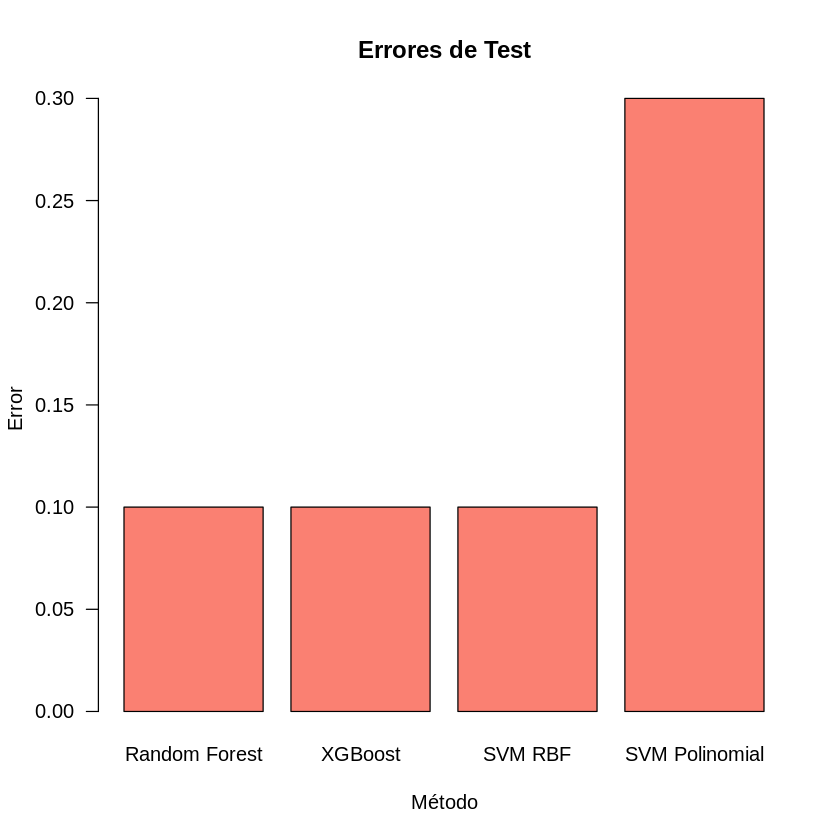

In [31]:
errores_test <- c(errorRF, errorXGBTest, errorRBFTest, errorPolTest)
nombres_metodos <- c("Random Forest", "XGBoost", "SVM RBF", "SVM Polinomial")

barplot(
  errores_test,
  names.arg = nombres_metodos, # Nombres de los métodos
  col = "salmon",              # Color de las barras
  main = "Errores de Test", # Título del gráfico
  xlab = "Método",             # Etiqueta del eje X
  ylab = "Error",              # Etiqueta del eje Y
  las = 1                      # Rotar etiquetas del eje X
)

### Comentarios

Como se puede observar en los valores presentados en el apartado anterior, logré identificar los parámetros óptimos para cada modelo que minimizan el error. A pesar de haber ejecutado cada modelo 20 veces, en la mayoría de los casos hubo varias combinaciones de parámetros que repetidamente producían el menor error posible. Para abordar esto, decidí probar todas esas combinaciones y quedarme con aquellas que generaron el menor error promedio. Los resultados que muestro aquí corresponden a esas configuraciones.

Es importante señalar que, en este caso, no utilicé el Out-of-Bag (OOB) para medir el error en RandomForest, ya que quería entrenar y probar sobre los mismos datos que en los otros modelos, buscando que la comparación fuera lo más justa posible.

Sin embargo, este dataset volvió a presentar dificultades al momento de comparar modelos debido al reducido número de registros disponibles (10 en el conjunto de prueba). En este contexto, un error del 10% implica que el modelo falló en predecir correctamente 1 de las 10 muestras de prueba, lo que genera una gran variabilidad en el porcentaje de error y dificulta una comparación significativa.

Además, al ser tan pocos registros, los distintos conjuntos de prueba pueden arrojar resultados muy variables, haciendo que los errores de los modelos fluctúen entre 0% y 30%. No obstante, los valores reportados aquí representan una aproximación a la media observada para cada modelo.

# Ejercicio 4

In [ ]:
dataX <- as.matrix(subset(RRL, select = -Tipo))

dataY <- RRL[, "Tipo"]

resultados <- getDatasets(dataX, dataY)
xBigTrain <- resultados$xBigTrain
yBigTrain <- resultados$yBigTrain
xBigTest <- resultados$xBigTest
yBigTest <- resultados$yBigTest

## Seleccion Parametros

### Funciones

In [ ]:
getDatasets <- function (x, y) {
  train_ratio <- 0.8

  n <- nrow(x)

  # Seleccionar índices aleatorios para entrenamiento
  train_indices <- sample(1:n, size = floor(train_ratio * n))

  # Crear los conjuntos de entrenamiento y prueba
  xBigTrain <- x[train_indices, ]
  yBigTrain <- y[train_indices]

  xBigTest <- x[-train_indices, ]
  yBigTest <- y[-train_indices]

  return(list(
    xBigTrain = xBigTrain,
    yBigTrain = yBigTrain,
    xBigTest = xBigTest,
    yBigTest = yBigTest
  ))
}

#### RF

In [ ]:
rrlRF <- function(x, y) {
  mtrys <- c(141, 70, 35, 17, 8, 4, 2, 1)
  arboles <- 1000
  tries <- 5

  erroresRF <- numeric(length(mtrys))

  for (i in 1:length(mtrys)) {

    mtry <- mtrys[i]
    error <- 0

    for (j in 1:tries) {
      rf_model <- randomForest(x = x, y = as.factor(y),
                              ntree = arboles,
                              mtry = mtry,
                              importance = FALSE)

      error <- error + tail(rf_model$err.rate[, "OOB"], 1)
    }

    erroresRF[i] <- error / tries
  }

  return (erroresRF)
}

#### XGB

In [ ]:
rrlXGB <- function(xTrain, yTrain, xTest, yTest) {
  XGB.nrounds <- 200
  etas <- c(0.5, 0.3, 0.1, 0.05, 0.01)
  XGB.max.depth <- 20

  erroresXGBTrain <- vector("list", length(etas))
  erroresXGBTest <- vector("list", length(etas))

  for (i in 1:length(etas)) {
    eta <- etas[i]

    errorDepthTrain <- numeric(XGB.max.depth)
    errorDepthTest <- numeric(XGB.max.depth)

    for (j in 1:XGB.max.depth) {
      xgb <- xgboost(data = xTrain, label = as.integer(yTrain) - 1,
                    objective = "binary:hinge", nrounds = XGB.nrounds,
                    early_stopping_rounds = 1000, eta = eta, max.depth = j,
                    colsample_bytree = 1, verbose = 0, subsample = 1)

      # Error en train
      predicciones <- predict(xgb, xTrain)
      errorDepthTrain <- mean((predicciones > 0.5) != as.integer(yTrain) - 1)

      # Error en test
      predicciones <- predict(xgb, xTest)
      errorDepthTest <- mean((predicciones > 0.5) != as.integer(yTest) - 1)
    }

    # Guardar errores por eta
    erroresXGBTrain[[i]] <- errorDepthTrain
    erroresXGBTest[[i]] <- errorDepthTest
  }

  return(list(erroresXGBTrain = erroresXGBTrain, erroresXGBTest = erroresXGBTest))
}

#### SVM RBF (Radial Basis Function)


In [ ]:
rrlRBF <- function(xTrain, yTrain, xTest, yTest) {
  costs <- c(1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000)

  gammas <- c(0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001)

  erroresRBFTrain <- vector("list", length(costs))
  erroresRBFTest <- vector("list", length(costs))

  for (i in 1:length(costs)) {
    cost <- costs[i]

    errorGammaTrain <- numeric(length(gammas))
    errorGammaTest <- numeric(length(gammas))

    for (j in 1:length(gammas)) {
      gamma <- gammas[j]

      svm_rbf <- suppressWarnings(
        svm(x = xTrain, y = as.factor(yTrain), kernel = "radial", cost = cost, gamma = gamma)
      )

      predTrain <- predict(svm_rbf, xTrain)
      errorGammaTrain <- mean(predTrain != yTrain)

      predTest <- predict(svm_rbf, xTest)
      errorGammaTest <- mean(predTest != yTest)
    }

    erroresRBFTrain[[i]] <- errorGammaTrain
    erroresRBFTest[[i]] <- errorGammaTest
  }

  return(list(erroresRBFTrain = erroresRBFTrain, erroresRBFTest = erroresRBFTest))
}

#### SVM Polinomial

In [ ]:
rrlPol <- function(xTrain, yTrain, xTest, yTest) {
  costs <- c(0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000)

  gammas <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)

  degrees <- c(1, 2, 3, 4, 5)

  erroresPolTrain <- vector("list", length(costs))
  erroresPolTest <- vector("list", length(costs))

  for (i in 1:length(costs)) {
    cost <- costs[i]

    errorGammaTrain <- vector("list", length(gammas))
    errorGammaTest <- vector("list", length(gammas))

    for (j in 1:length(gammas)) {
      gamma <- gammas[j]

      errorDegreeTrain <- numeric(length(degrees))
      errorDegreeTest <- numeric(length(degrees))

      for (l in 1:length(degrees)) {
        degree <- degrees[l]

        svm_pol <- suppressWarnings(
          svm(x = xTrain, y = as.factor(yTrain), kernel = "polynomial",
              cost = cost, degree = degree, gamma = gamma)
        )

        predTrain <- predict(svm_pol, xTrain)
        errorDegreeTrain <- mean(predTrain != yTrain)

        predTest <- predict(svm_pol, xTest)
        errorDegreeTest <- mean(predTest != yTest)
      }

      errorGammaTrain[[j]] <- errorDegreeTrain
      errorGammaTest[[j]] <- errorDegreeTest
    }

    erroresPolTrain[[i]] <- errorGammaTrain
    erroresPolTest[[i]] <- errorGammaTest
  }

  return(list(erroresPolTrain = erroresPolTrain, erroresPolTest = erroresPolTest))
}

### Calculos

In [ ]:
mtrys <- c(69, 34, 17, 8, 4, 2, 1)
best_rf_count <- numeric(length(mtrys))

etas <- c(0.5, 0.3, 0.1, 0.05, 0.01)
max_depth <- 1:20
best_xgb_count <- matrix(0, nrow = length(etas), ncol = length(max_depth),
                            dimnames = list(etas, max_depth))

costsRBF <- c(1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000)
gammasRBF <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
best_rbf_count <- matrix(0, nrow = length(costsRBF), ncol = length(gammasRBF),
                            dimnames = list(costsRBF, gammasRBF))

costsPol <- c(0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000)
gammasPol <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
degreesPol <- c(1, 2, 3, 4, 5)
best_pol_count <- array(0, dim = c(length(costsPol), length(gammasPol), length(degreesPol)),
                           dimnames = list(costsPol, gammasPol, degreesPol))

resultados <- getDatasets(xBigTrain, yBigTrain)
xTrain <- resultados$xBigTrain
yTrain <- resultados$yBigTrain
xTest <- resultados$xBigTest
yTest <- resultados$yBigTest

# RF
erroresRF <- rrlRF(xBigTrain, yBigTrain)

min_error <- min(erroresRF)
best_rf_count[erroresRF == min_error] <- best_rf_count[erroresRF == min_error] + 1

# XGB
resultadosXGB <- rrlXGB(xTrain, yTrain, xTest, yTest)
erroresXGBTest <- resultadosXGB$erroresXGBTest

min_error <- Inf
best_eta_index <- NA
best_depth_index <- NA
for (eta_idx in seq_along(etas)) {
  for (depth_idx in seq_along(max_depth)) {
    error_promedio <- erroresXGBTest[[eta_idx]][depth_idx]
    if (error_promedio < min_error) {
      min_error <- error_promedio
    }
  }
}

for (eta_idx in seq_along(etas)) {
  for (depth_idx in seq_along(max_depth)) {
    error_promedio <- erroresXGBTest[[eta_idx]][depth_idx]
    if (error_promedio == min_error) {
      best_xgb_count[eta_idx, depth_idx] <- best_xgb_count[eta_idx, depth_idx] + 1
    }
  }
}

# SVM RBF
resultadosRBF <- rrlRBF(xTrain, yTrain, xTest, yTest)
erroresRBFTest <- resultadosRBF$erroresRBFTest

min_error <- Inf
best_cost_index <- NA
best_gamma_index <- NA
for (cost_idx in seq_along(costsRBF)) {
  for (gamma_idx in seq_along(gammasRBF)) {
    error_promedio <- erroresRBFTest[[cost_idx]][gamma_idx]
    if (error_promedio < min_error) {
      min_error <- error_promedio
    }
  }
}

for (cost_idx in seq_along(costsRBF)) {
  for (gamma_idx in seq_along(gammasRBF)) {
    error_promedio <- erroresRBFTest[[cost_idx]][gamma_idx]
    if (error_promedio == min_error) {
      best_rbf_count[cost_idx, gamma_idx] <- best_rbf_count[cost_idx, gamma_idx] + 1
    }
  }
}

# SVM Polinomial
resultadosPol <- rrlPol(xTrain, yTrain, xTest, yTest)
erroresPolTest <- resultadosPol$erroresPolTest

min_error <- Inf
for (cost_idx in seq_along(costsPol)) {
  for (gamma_idx in seq_along(gammasPol)) {
    for (degree_idx in seq_along(degreesPol)) {
      error_promedio <- erroresPolTest[[cost_idx]][[gamma_idx]][degree_idx]
      if (error_promedio < min_error) {
        min_error <- error_promedio
      }
    }
  }
}

for (cost_idx in seq_along(costsPol)) {
  for (gamma_idx in seq_along(gammasPol)) {
    for (degree_idx in seq_along(degreesPol)) {
      error_promedio <- erroresPolTest[[cost_idx]][[gamma_idx]][degree_idx]
      if (error_promedio == min_error) {
        best_pol_count[cost_idx, gamma_idx, degree_idx] <- best_pol_count[cost_idx, gamma_idx, degree_idx] + 1
      }
    }
  }
}

cat("----- RF -----\n")
print(setNames(best_rf_count, mtrys))

cat("----- XGB -----\n")
print(best_xgb_count)

cat("----- SVM RBF -----\n")
print(best_rbf_count)

cat("----- SVM Polinomial -----\n")
print(best_pol_count)


----- RF -----
69 34 17  8  4  2  1
 0  0  0  1  0  0  0

----- XGB -----
     1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
0.5  0 0 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0
0.3  1 0 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0
0.1  0 0 0 1 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0
0.05 0 0 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0
0.01 0 0 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0

----- SVM RBF -----
      1e-05 1e-04 0.001 0.01 0.1 1 10
1000      0     0     0    0   0 0  0
10000     0     0     0    0   0 0  0
1e+05     0     0     0    0   0 0  0
1e+06     0     0     0    0   0 0  0
1e+07     0     0     0    0   0 0  0
1e+08     1     0     0    0   0 0  0
1e+09     0     0     0    0   0 0  0

----- SVM Polinomial -----
, , 1

      1e-05 1e-04 0.001 0.01 0.1 1 10
0.1       0     0     0    0   0 0  0
1         0     0     0    0   0 0  0
10        0     0     0    0   0 1  0
100       0     0     0    0   1 0  0
1000      0     0     0    1   0 0  0
10000     0     0     1    0   0 0  0
1e+05     0     1     0    0   0 0  0
1e+06     0     0     0    0   0 0  0
1e+07     0     0     0    0   0 0  0

, , 2

      1e-05 1e-04 0.001 0.01 0.1 1 10
0.1       0     0     0    0   0 0  0
1         0     0     0    0   0 0  0
10        0     0     0    0   0 0  0
100       0     0     0    0   0 0  0
1000      0     0     0    0   0 0  0
10000     0     0     0    0   0 0  0
1e+05     0     0     0    0   0 0  0
1e+06     0     0     0    0   0 0  0
1e+07     0     0     0    0   0 0  0

, , 3

      1e-05 1e-04 0.001 0.01 0.1 1 10
0.1       0     0     0    0   0 0  0
1         0     0     0    0   0 0  0
10        0     0     0    0   0 0  0
100       0     0     0    0   0 0  0
1000      0     0     0    0   0 0  0
10000     0     0     0    0   0 0  0
1e+05     0     0     0    0   0 0  0
1e+06     0     0     0    0   0 0  0
1e+07     0     0     0    0   0 0  0

, , 4

      1e-05 1e-04 0.001 0.01 0.1 1 10
0.1       0     0     0    0   0 0  0
1         0     0     0    0   0 0  0
10        0     0     0    0   0 0  0
100       0     0     0    0   0 0  0
1000      0     0     0    0   0 0  0
10000     0     0     0    0   0 0  0
1e+05     0     0     0    0   0 0  0
1e+06     0     0     0    0   0 0  0
1e+07     0     0     0    0   0 0  0

, , 5

      1e-05 1e-04 0.001 0.01 0.1 1 10
0.1       0     0     0    0   0 0  0
1         0     0     0    0   0 0  0
10        0     0     0    0   0 0  0
100       0     0     0    0   0 0  0
1000      0     0     0    0   0 0  0
10000     0     0     0    0   0 0  0
1e+05     0     0     0    0   0 0  0
1e+06     0     0     0    0   0 0  0
1e+07     0     0     0    0   0 0  0

### Comentarios

Debido al tamaño del dataset y al tiempo que tardaba en procesarse (cerca de 2 horas en total), utilicé el mismo conjunto de parámetros que en el ejercicio anterior.

Dado que había muchas más muestras que en el dataset Lampone, opté por ejecutar el modelo una sola vez para cada combinación de parámetros. Además, al contar con más datos tanto para entrenamiento como para prueba, no ocurrió lo mismo que en Lampone, donde existían muchas combinaciones con errores similares. En este caso, hubo muy pocas combinaciones que resultaron en el menor error (en ocasiones, solo una), lo cual facilitó la elección final de los parámetros óptimos.

## Comparacion final

In [ ]:
# RF
rf_model <- randomForest(x = xBigTrain, y = as.factor(yBigTrain),
                        ntree = 1000,
                        mtry = 8,
                        importance = FALSE)

predTest <- predict(rf_model, xBigTest)
errorRF <- mean(predTest != yBigTest)

# XGB
xgb <- xgboost(data = xBigTrain, label = as.integer(yBigTrain) - 1,
              objective = "binary:hinge", nrounds = 200,
              early_stopping_rounds = 1000, eta = 0.3, max.depth = 1,
              colsample_bytree = 1, verbose = 0, subsample = 1)

predicciones <- predict(xgb, xBigTest)
errorXGBTest <- mean((predicciones > 0.5) != as.integer(yBigTest) - 1)

# SVM RBF
svm_rbf <- suppressWarnings(
  svm(x = xBigTrain, y = as.factor(yBigTrain), kernel = "radial", cost = 100000000, gamma = 0.00001)
)

predTest <- predict(svm_rbf, xBigTest)
errorRBFTest <- mean(predTest != yBigTest)

# SVM Polinomial
svm_pol <- suppressWarnings(
  svm(x = xBigTrain, y = as.factor(yBigTrain), kernel = "polynomial",
      cost = 100, degree = 1, gamma = 0.1)
)

predTest <- predict(svm_pol, xBigTest)
errorPolTest <- mean(predTest != yBigTest)

In [ ]:
errores_test <- c(errorRF, errorXGBTest, errorRBFTest, errorPolTest)
nombres_metodos <- c("Random Forest", "XGBoost", "SVM RBF", "SVM Polinomial")

barplot(
  errores_test,
  names.arg = nombres_metodos, # Nombres de los métodos
  col = "salmon",              # Color de las barras
  main = "Errores de Test", # Título del gráfico
  xlab = "Método",             # Etiqueta del eje X
  ylab = "Error",              # Etiqueta del eje Y
  las = 2                      # Rotar etiquetas del eje X
)

la imagen con los errores esta adjunta

### Comentarios

Personalmente, considero que Random Forest y XGBoost dieron buenos resultados, ambos rondando un 4% de error, donde RF casi siempre obtuvo mejores resultados que XGB. Creo que esto puede deberse a que no se seleccionaron correctamente los parámetros para XGB, ya que, con una adecuada configuración, este modelo debería superar a RF.

En cuanto a los modelos SVM, estos casi siempre obtuvieron resultados similares, con un error cercano al 9%. Si bien uno podría pensar que siguen siendo buenos modelos debido a su bajo error, al comparar con RF, que con una selección de parámetros tan simple (solo eligiendo un Mtry) logró menos de la mitad de ese error, pienso que los modelos SVM no son los más adecuados para este problema. No obstante, sigue siendo posible que, con una mejor selección de variables o parámetros, se pudieran haber obtenido mejores resultados.